In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
fontsize = 16
lw = 2

props = dict(boxstyle='round, pad=0.5', facecolor='white', edgecolor='black', 
             linewidth=2, mutation_aspect=0.8, pad=0.3)

blues = sns.color_palette('Blues', 20)
palette = [blues[1], blues[13]]

cmap2 = 'coolwarm'

In [3]:
path = '01_Data/03_DirectLFQ_Quan/'

names = ['MBR', '+10xME']
counts = []
for i, name in enumerate(names):
    
    quan = pd.read_csv(path + 'f_' + name + '_report.tsv.ion_intensities.tsv', sep='\t')
    quan = quan.drop(columns=[c for c in quan if 'c_24h' in c])
    
    quan_cols = [c for c in quan if 'KK' in c]
    quan = quan.replace(0, np.nan).dropna(how='all', subset=quan_cols)
    quan = quan.set_index('protein')
    
    count = quan.groupby(quan.index).count()
    count.rename(columns={'ion': 'Ion sum'}, inplace=True)
    count['Mean per sample'] = count[quan_cols].mean(axis=1).replace(0, np.nan)
    count['Mean if identified'] = count[quan_cols].replace(0, np.nan).mean(axis=1).replace(0, np.nan)
    count['Log mean per sample'] = np.log2(count['Mean per sample'])
    count['Log mean if identified'] = np.log2(count['Mean if identified'])
    count['Log sum'] = np.log2(count['Ion sum'])
    
    counts.append(count)


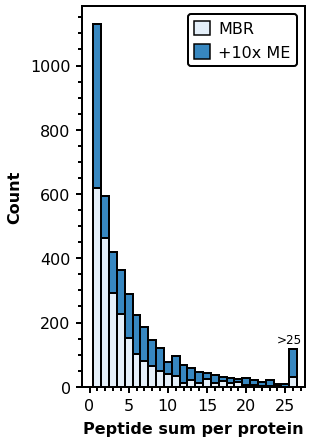

In [4]:
fig, ax = plt.subplots(1,1, figsize=(4,7))

thresh = 25
handles = []
for i in range(2):
    data = counts[i][counts[i]['Ion sum'] <= thresh]
    sns.histplot(data=data, x='Ion sum', color=palette[i], binrange=[0, thresh], bins=thresh,
                 linewidth=lw, edgecolor='k', alpha=1, discrete=True, ax=ax, zorder=1-i)

    ax.bar(x=thresh+1, height=len(counts[i][counts[i]['Ion sum'] > thresh]), width=1, color=palette[i],
           linewidth=lw, edgecolor='k', zorder=1-i)
    
    handles.append(mpl.patches.Patch(facecolor=palette[i], edgecolor='k', lw=lw-0.5))

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(lw)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', pad=5, length=lw*3, width=lw, labelsize=fontsize)
ax.tick_params(axis='both', which='minor', length=lw*2, width=lw)

ax.set_xlabel('Peptide sum per protein', fontsize=fontsize, weight='bold', labelpad=8)
ax.set_ylabel('Count', fontsize=fontsize, weight='bold', labelpad=8)
ax.set_xlim([-1, thresh+2.5])
ax.set_xticks(range(0,26,5))
   
ax.text(x=thresh+0.5, y=len(counts[1][counts[1]['Ion sum'] > thresh])*1.15, s='>'+str(thresh), fontsize=fontsize-4, ha='center')

labels = [name.replace('x', 'x ') for name in names]
legend = ax.legend(handles=handles, labels=labels, fontsize=fontsize, handlelength=1, handleheight=1,
                   handletextpad=0.5, edgecolor='k', framealpha=1, loc=0)
legend.get_frame().set_linewidth(lw)

# plt.savefig('02_Figures/IFN_low-input_Peptide_Sum_Histogram.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_Peptide_Sum_Histogram.pdf', dpi=400, bbox_inches='tight')

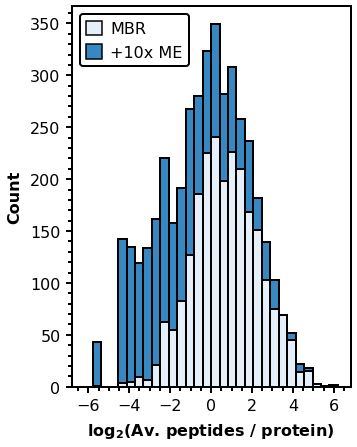

In [5]:
fig, ax = plt.subplots(1,1, figsize=(5,7))

for i in range(2):
    sns.histplot(data=counts[i], x='Log mean per sample', color=palette[i], binrange=[-6.2, 6.2], bins=30, 
                 linewidth=lw, edgecolor='k', alpha=1, ax=ax, zorder=1-i)

for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(lw)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', pad=5, length=lw*3, width=lw, labelsize=fontsize)
ax.tick_params(axis='both', which='minor', length=lw*2, width=lw)

ax.set_ylabel('Count', fontsize=fontsize, weight='bold', labelpad=8)
ax.set_xlabel('log'+r'$\bf{_{2}}$'+'(Av. peptides / protein)', fontsize=fontsize, weight='bold', labelpad=8)

ax.set_xticks(range(-6, 7, 2))

legend = ax.legend(handles=handles, labels=labels, fontsize=fontsize, handlelength=1, handleheight=1,
                   handletextpad=0.5, edgecolor='k', framealpha=1, loc=2)
legend.get_frame().set_linewidth(lw)

# plt.savefig('02_Figures/IFN_low-input_Peptide_Average_Histogram.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_Peptide_Average_Histogram.pdf', dpi=400, bbox_inches='tight')

In [6]:
merge = counts[0].drop(columns=quan_cols).merge(counts[1].drop(columns=quan_cols), 
                                                how='outer', left_index=True, right_index=True)
merge['Ratio'] = merge['Mean if identified_y'] / merge['Mean if identified_x']

Text(0.5, 1.0, 'Ratio')

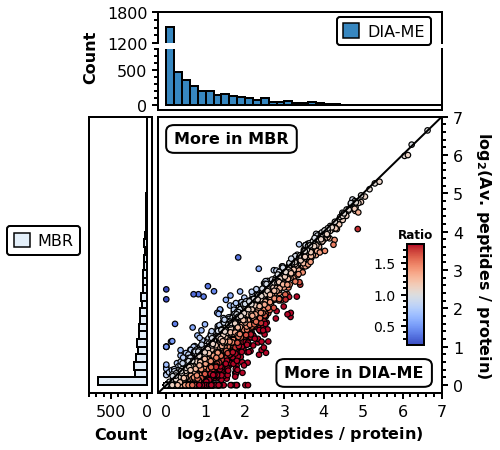

In [7]:
hist_limit = 1800
hist_cutoff = 1200
mean_limit = 7
vmin = 0.2
vmax = 1.8

fig, ax = plt.subplots(3,3, figsize=(7,7), gridspec_kw={'width_ratios': [1,2,9], 'height_ratios': [1,2,9]})
plt.subplots_adjust(wspace=0.05, hspace=0.05)
axs = fig.axes
for i in [0,1,3,4,6]:
    fig.delaxes(axs[i])

for ax in axs:
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', pad=5, length=lw*3, width=lw, labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', length=lw*2, width=lw)

for i in [2, 5]:  # upper histogram
    sns.histplot(data=counts[1], x='Log mean if identified', color=palette[1], binrange=[0, mean_limit], 
                 bins=35, linewidth=lw, alpha=1, ax=axs[i])
    
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    
    axs[i].set_xlim([-0.2, mean_limit])
    axs[i].set_xticks([])

axs[2].set_ylim([hist_cutoff, hist_limit])
axs[2].set_yticks([hist_cutoff, hist_limit])
axs[2].spines['bottom'].set_visible(False)

axs[5].set_ylim([-75, hist_cutoff-400])
axs[5].spines['top'].set_visible(False)
axs[5].set_yticks([0, 500])
axs[5].text(x=-2.1, y=hist_cutoff-500, s='Count', fontsize=fontsize, weight='bold', rotation=90, va='center')

# left histogram
sns.histplot(data=counts[0], y='Log mean if identified', color=palette[0], binrange=[0, mean_limit],
             bins=35, linewidth=lw, alpha=1, ax=axs[7]) 

axs[7].set_xlabel('Count', fontsize=fontsize, weight='bold', labelpad=8)
axs[7].invert_xaxis()
axs[7].set_xlim([hist_cutoff-400, -75])
axs[7].set_yticks([])
axs[7].set_yticklabels([])
axs[7].set_ylabel('') 
axs[7].set_ylim([-0.2, mean_limit])

# central scatter
sns.scatterplot(data=merge, x='Log mean if identified_y', y='Log mean if identified_x', hue='Ratio', hue_norm=(vmin, vmax), 
                palette=cmap2, edgecolor='k', s=30, linewidth=1.2, alpha=1, ax=axs[8])
axs[8].axline((0,0), (6.3,6.3), color='black', linestyle='solid', lw=2)

axs[8].set_ylabel('log'+r'$\bf{_{2}}$'+'(Av. peptides / protein)', fontsize=fontsize, weight='bold', labelpad=30, rotation=270)
axs[8].set_xlabel('log'+r'$\bf{_{2}}$'+'(Av. peptides / protein)', fontsize=fontsize, weight='bold', labelpad=5)
axs[8].set_xlim([-0.2, mean_limit])
axs[8].set_xticks(range(0,8))
axs[8].set_ylim([-0.2, mean_limit])
axs[8].yaxis.tick_right()
axs[8].yaxis.set_label_position('right')

axs[8].text(x=0.2, y=6.3, s='More in MBR', bbox=props, fontsize=fontsize, weight='bold')
axs[8].text(x=3, y=0.2, s='More in DIA-ME', bbox=props, fontsize=fontsize, weight='bold')

axs[8].legend().remove()

legend = axs[5].legend(handles=[handles[1]], labels=['DIA-ME'], fontsize=fontsize, handlelength=1, handleheight=1,
                       handletextpad=0.5, edgecolor='k', framealpha=1, loc=(0.63,1.06))               
legend.get_frame().set_linewidth(lw)

legend2 = axs[7].legend(handles=[handles[0]], labels=[labels[0]], fontsize=fontsize, handlelength=1, handleheight=1,
                       handletextpad=0.5, edgecolor='k', framealpha=1, loc=(-1.3,0.5))                 
legend2.get_frame().set_linewidth(lw)

# plot colormap
cax = fig.add_axes([0.83,0.22,0.035,0.2])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap2, norm=norm), cax=cax)

for axis in ['top', 'bottom', 'left', 'right']:
    cax.spines[axis].set_visible(True)
    cax.spines[axis].set_linewidth(2)
        
cax.yaxis.set_label_position('left')
cax.yaxis.tick_left()

cax.minorticks_on()
cax.tick_params(axis='both', which='major', pad=5, length=lw*3, width=lw, labelsize=fontsize-2)
cax.tick_params(axis='both', which='minor', length=lw*2, width=lw)
cax.set_title('Ratio', weight='bold')

# plt.savefig('02_Figures/IFN_low-input_Peptide_Ratio_Scatter.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_Peptide_Ratio_Scatter.pdf', dpi=400, bbox_inches='tight')